In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2
import numpy as np

In [2]:
import glob
calibration_images_dir='../camera_cal'
calibration_images=glob.glob(calibration_images_dir+'/*.jpg')
print("Number of images in calibration directory: {}".format(len(calibration_images)))

Number of images in calibration directory: 20


Found chessboard corners


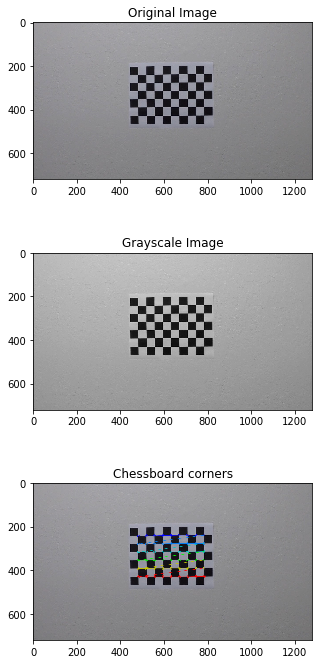

In [9]:
# Read one calibration image and display 
_img_color=cv2.cvtColor(cv2.imread(calibration_images[1]),cv2.COLOR_BGR2RGB)
_img_gray=cv2.cvtColor(_img_color,cv2.COLOR_RGB2GRAY)
# Count chessboard corners (manually done)
nx=9
ny=6
ret,corners=cv2.findChessboardCorners(_img_gray,(nx,ny),None)
fig=plt.figure(figsize=(5,12))
plt.subplot(311)
plt.title("Original Image")
plt.imshow(_img_color)
plt.subplot(312)
plt.title("Grayscale Image")
plt.imshow(_img_gray,cmap='gray')
if ret==True:
    print("Found chessboard corners")
    cv2.drawChessboardCorners(_img_color,(nx,ny),corners,ret)
    plt.subplot(313)
    plt.title("Chessboard corners")
    plt.imshow(_img_color)

In [10]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# Read all the calibration images and find corners
objectpoints=[]
imagepoints=[]
for calibration_image in calibration_images:
    img_color=cv2.imread(calibration_image)
    img_gray=cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    ret,corners=cv2.findChessboardCorners(img_gray,(nx,ny),None)
    if ret == True:
        objectpoints.append(objp)
        corners2=cv2.cornerSubPix(img_gray,corners,(11,11),(-1,-1),criteria)
        imagepoints.append(corners2)        

In [11]:
# Get Calibration Matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, _img_gray.shape[::-1],None,None)

Undistorted Image


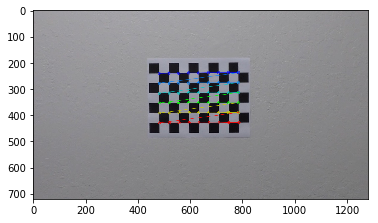

In [12]:
_undistorted_image=cv2.undistort(_img_color,mtx,dist,None,mtx)
print("Undistorted Image")
plt.imshow(_undistorted_image)

Simple function to get undistorted image

In [13]:
def undistort_image(img):
    return cv2.undistort(img,mtx,dist,None,mtx)

In [14]:
# M = cv2.getPerspectiveTransform(src, dst)
# Minv = cv2.getPerspectiveTransform(dst, src)

# warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)


Gradient Thresholding

In [15]:
image=cv2.imread('../test_images/test3.jpg')
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

In [16]:
# Sobel in X & Y 
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1)
abs_sobelx = np.absolute(sobelx)
# Scaling: Recommended on lecture slide
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

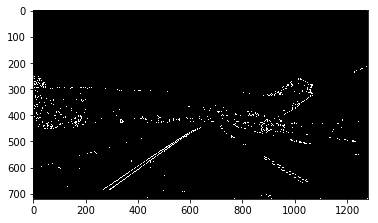

In [24]:
grad_thresh_max=110
grad_thresh_min=30
sxbinary=np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= grad_thresh_min) & (scaled_sobel <= grad_thresh_max)] = 1
plt.imshow(sxbinary,cmap='gray')

In [27]:
# Function to apply Soble - Lecture/Quiz outputs
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [75]:
ksize=11
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 110))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 250))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 150))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.5, 1.2))
combined = np.zeros_like(dir_binary)
combined[((gradx==1)&(grady==1))|((mag_binary==1)&(dir_binary==1))] = 1

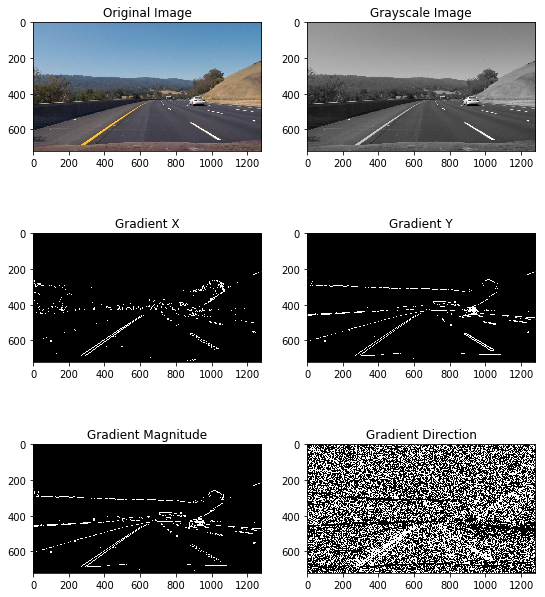

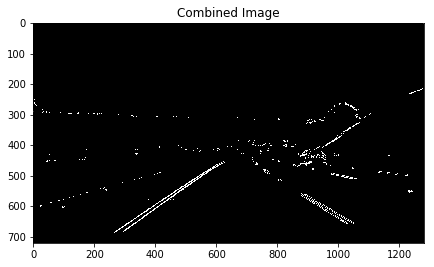

In [76]:
# Plot all the images;
plt.figure(figsize=(9,11))
plt.subplot(321)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.subplot(322)
plt.title("Grayscale Image")
plt.imshow(gray, cmap='gray')
plt.subplot(323)
plt.title("Gradient X")
plt.imshow(gradx,cmap='gray')
plt.subplot(324)
plt.title("Gradient Y")
plt.imshow(grady,cmap='gray')
plt.subplot(325)
plt.title("Gradient Magnitude")
plt.imshow(mag_binary,cmap='gray')
plt.subplot(326)
plt.title("Gradient Direction")
plt.imshow(dir_binary,cmap='gray')

fig=plt.figure(figsize=(7,6))
plt.title("Combined Image")
plt.imshow(combined, cmap='gray')

Color Thresholding

In [77]:
def hls_threshold(img,thresh=(0,255)):
    hls=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    s_channel=hls[:,:,2]
    s_bin=np.zeros_like(s_channel)
    s_bin[(s_channel>=thresh[0])&(s_channel<=thresh[1])] = 1
    return s_bin

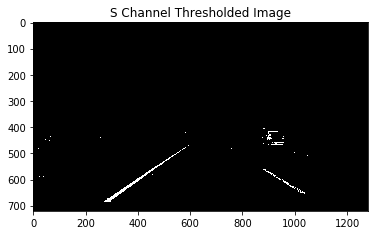

In [80]:
hls_binary=hls_threshold(image,(170,255))
plt.imshow(hls_binary,cmap='gray')
plt.title("S Channel Thresholded Image")

In [81]:
def combine_bin_images(img1,img2):
#     Or operation b/n images
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(img1 == 1) | (img2 == 1)] = 1
    return combined_binary

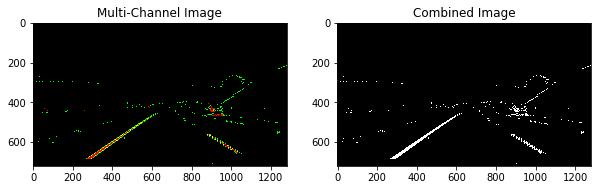

In [82]:
# Show S Channel threshold & Gradient threshold in multi-channel image
_mul_channel=np.dstack((hls_binary,combined,np.zeros_like(hls_binary)))
_combined=combine_bin_images(hls_binary,combined)

fig=plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("Multi-Channel Image")
plt.imshow(_mul_channel)
plt.subplot(122)
plt.title("Combined Image")
plt.imshow(_combined,cmap='gray')

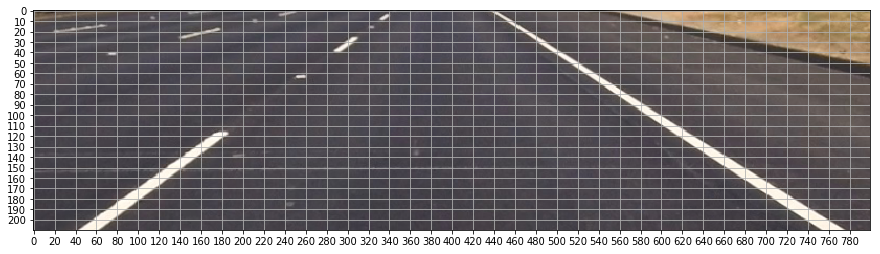

In [130]:
# Perspective transform
# Read a straigt line image
st_line_image='../test_images/straight_lines2.jpg'
_st_image=cv2.undistort(cv2.cvtColor(cv2.imread(st_line_image),cv2.COLOR_BGR2RGB),mtx,dist,None,mtx)
# Take the small part of image and display zoomed
_roi_image=_st_image[450:660,250:1050]
fig=plt.figure(figsize=(15,6))
ax = fig.gca()
ax.set_xticks(np.arange(0, _roi_image.shape[1], 20))
ax.set_yticks(np.arange(0, _roi_image.shape[0], 10))
plt.grid()
plt.imshow(_roi_image)

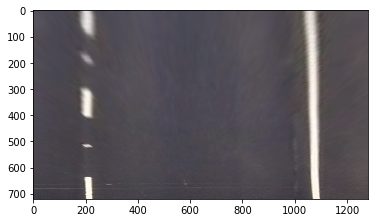

In [160]:
src_left_top=(580,460)
src_left_bottom=(290,660)
src_right_top=(710,460)
src_right_bottom=(1030,660)

dst_left_top=(200,100)
dst_left_bottom=(200,720)
dst_right_top=(1100,100)
dst_right_bottom=(1100,720)

_exchange = lambda x:(x[1],x[0])
# cv2.line(_st_image,src_left_bottom,src_left_top,(255,0,0),5)
# cv2.line(_st_image,src_left_top,src_right_top,(255,0,0),5)
# cv2.line(_st_image,src_right_top,src_right_bottom,(255,0,0),5)
# plt.imshow(_st_image)

_src=np.float32([src_left_top,src_left_bottom,src_right_bottom,src_right_top])
_dst=np.float32([dst_left_top,dst_left_bottom,dst_right_bottom,dst_right_top])
M=cv2.getPerspectiveTransform(_src,_dst)
Minv = cv2.getPerspectiveTransform(_dst, _src)
_warped=cv2.warpPerspective(_st_image,M,dsize=_exchange(_st_image.shape[:2]))
plt.imshow(_warped)

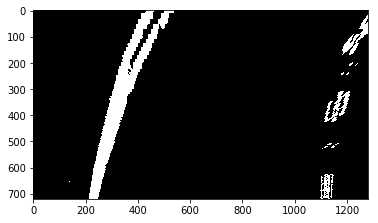

In [137]:
# See the result on thresholded image:
_combined_perspective=cv2.warpPerspective(_combined,M,dsize=_exchange(_st_image.shape[:2]))
plt.imshow(_combined_perspective,cmap='gray')

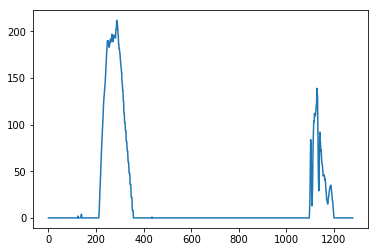

In [142]:
histogram = np.sum(_combined_perspective[_combined_perspective.shape[0]//2:,:], axis=0)
plt.plot(histogram)

(720, 0)

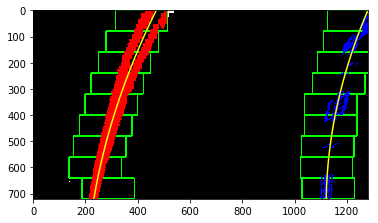

In [148]:
binary_warped=np.copy(_combined_perspective)
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [154]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

2330.01296629 1762.9152579


In [159]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

733.884782182 m 578.786532497 m


Warping Image

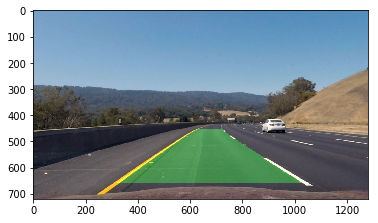

In [165]:
warp_zero=np.zeros_like(_combined).astype(np.uint8)
color_warp=np.dstack((warp_zero,warp_zero,warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
undist=cv2.undistort(cv2.cvtColor(image,cv2.COLOR_BGR2RGB),mtx,dist,None,mtx)
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [168]:
# Save all the important data
np.savez('calibration_params',mtx=mtx,dist=dist)
np.savez('perspective_maps',M=M,Minv=Minv)

In [170]:
color_warp.shape

(720, 1280, 3)

In [171]:
w=np.zeros_like(image)

In [172]:
w.shape

(720, 1280, 3)